### scikit-learnは２章で考えたパーセプトロンやADALINEなどをユーザフレンドリーなAPIを使って実装できるプログラム

irisのデータセットは人気のデータセットゆえにこのライブラリに組み込まれている

iris = [がく片の長さ, がく片の幅, 花びらの長さ, 花びらの幅]

In [2]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
"""行は指定せず列を指定、今回は花びらの長さと花びらの幅を算出"""
X = iris.data[:, [2, 3]]
#iris.targetでクラスラベルを取得
Y = iris.target
print("クラスラベル:", np.unique(Y))

クラスラベル: [0 1 2]


In [3]:
from sklearn.model_selection import train_test_split
#訓練データとテストデータに分割
#全体の30%をテストデータにする
"""
stratifyにクラスラベルYを設定するとデータセットの特性を考慮して分割させることができる
つまり、訓練サブセットとテストサブセットに含まれるクラスラベルの比率が入力データセットと同じになる
"""
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size = 0.3, random_state=1, stratify=Y
)

特徴量をスケーリングする
勾配降下法は特徴量のスケーリングの恩恵を受ける
データセットに標準正規分布の0平均と単位分散という特性が与えられる。N(0, 1)ってやつ
手法としては、各特徴量の平均をずらして中身が0になるようにし、標準偏差を１にする
``
x' = (x - μ)/δ
``

In [4]:
from sklearn.preprocessing import StandardScaler
"""特徴量を標準化する"""
sc = StandardScaler()
"""訓練データの平均と標準偏差を計算"""
sc.fit(X_train)
"""
平均と標準偏差を用いて標準化
transformメソッドはfitメソッドで推定した平均値パラメタと標準偏差パラメタを使って訓練データを標準化する。
テストデータも標準化する(下)
"""
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [5]:
from sklearn.linear_model import Perceptron
#パーセプトロンのインスタンス作成(ライブラリから)
ppn  = Perceptron(eta0 = 0.01, random_state=1) #random_stateを1にすることで、エポックごとに訓練データセットの並び替えが再現できるようになる
ppn.fit(X_train_std, y_train)


Perceptron(eta0=0.01, random_state=1)

訓練データを学習させた後は、テストデータで予測を実施しないといけない。



テストデータセットに対して正しく分類がなされると、訓練データを有効に学習させることができたと考えられる。

その際に使われる指標が`誤分類率`である。正解率 = 1 - `誤分類率`

In [6]:
"""テストデータで予測、predictメソッドを使用"""
y_pred = ppn.predict(X_test_std)
"""誤分類のデータ点の個数を表示"""
print("誤分類: %d " % (y_test != y_pred).sum()) #pythonでもprintfもどきができる ,を%にすればいい

誤分類: 2 


scikit-learnの性能指標計算モジュールmetricsで正解率を計算

In [7]:
from sklearn.metrics import accuracy_score
#分類の正解率を表示
print("正解率: %3f" % accuracy_score(y_test, y_pred))

正解率: 0.955556


In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#２次元のデータセットの決定境界を可視化する関数

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))]) #a = [0, 0, 20, 30, 10, 10]でnp.unique(a) >>> [0, 10, 20, 30] uniqueってのは重複は数えん

    # 決定領域をプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    #グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))#グリッドポイントとは、一定の間隔で点を配置した座標の集合()
    #各特徴量を１次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T) #.Tは転置, .ravelは多次元配列を一次元にする
    #予測結果を元のグリッドポイントのデータサイズに変換(2次元に変換)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap) #contourf(格子点のx座標の配列, 格子点のy座標の配列, 値の配列)
    plt.xlim(xx1.min(), xx1.max()) #x軸の表示範囲を設定
    plt.ylim(xx2.min(), xx2.max()) #y軸の表示範囲を設定

    # plot class examples
    for idx, cl in enumerate(np.unique(y)): #enumerateはインデックスと要素の２つを取るidx -> 0, cl -> -1より colors[idx]は赤
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    """テストデータ点を目立たせる(点を○で表示)"""
    if test_idx:
        #全てのデータ点をプロット
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c = " ", edgecolor= "black", 
                    alpha=1.0, linewidth=1, marker="o", s=100, label="test set")

/var/folders/64/qzdb2kkj5c7934_prcdj4xvr0000gn/T/ipykernel_71109/3351863578.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not  

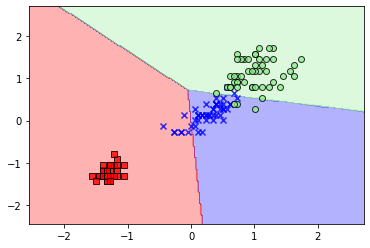

In [9]:
#訓練データとテストデータの特徴量を行方向に結合
X_combined_std = np.vstack((X_train_std, X_test_std))
#訓練データとテストデータのクラスラベルを結合
y_combined = np.hstack((y_train, y_test))
#決定領域のプロット
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range(105, 150))
# 軸のラベルの設定
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
# 凡例の設定(左上に配置)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()



完全な線形分離が不可能なデータセットでは、上のようにパーセプトロンアルゴリズムでは決して収束しない。
次にやるのは線形分離できない場合でもコストの最小値に収束する強力な線形分類器を取り上げる。

## ここで取り扱うのはロジスティック回帰モデル
logit(p) = log p/(1-p)をロジット関数といい、pは正事象の確率。pを知りたいので、ロジット関数の逆関数を考える。それが、シグモイド関数である。以下はシグモイド関数の実装

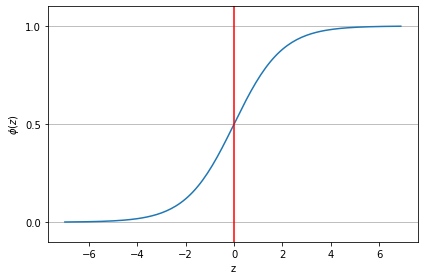

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#シグモイド関数の定義
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
# 0.1刻みで-7以上7未満のデータを生成
z = np.arange(-7, 7, 0.1)
# 生成したデータでシグモイド関数を実行
phi_z = sigmoid(z)
# 元のデータとシグモイド関数の出力をプロット
plt.plot(z, phi_z)
# 垂直線を追加(z=0)
plt.axvline(x=0.0, color='r')
# y軸の上限/下限を設定
plt.ylim(-0.1, 1.1)
# 軸のラベルを設定
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
# y軸の目盛りを追加
plt.yticks([0.0, 0.5, 1.0])
# Axesクラスのオブジェクトの取得
"""現在アクティブなAxesオブジェクトを返す(今から描画しようとしているもの)"""
ax = plt.gca()
# y軸のメモリ上に水平グリッド線を追加
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()


ADALINEが恒等関数との誤差
ロジスティック回帰はシグモイド関数との誤差

In [ ]:
class LogisticRegressionGD(object):
    """勾配降下法に基づくロジスティック回帰分類機
    
    パラメータ
    ------------
    eta : float
        学習率 (0.0より大きく1.0以下の値)
    n_iter : int
        トレーニングデータのトレーニング回数
    random_state : int
        重みを初期化するための乱数シード

    属性
    ------------
    w_ : 1次元配列
        適合後の重み
    cost_ : リスト
        各エポックでの誤差平方和のコスト関数

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ トレーニングデータに適合させる

        パラメータ
        ------------
        X : {配列のようなデータ構造}, shape = [n_samples, n_features]
        トレーニングデータ
        n_samplesはサンプルの個数、n_featuresは特徴量の個数
        y : 配列のようなデータ構造, shape = [n_samples]
        目的変数

        戻り値
        ------------
        self : object

        """
        rgen = np.random.RandomState(seed = self.random_state) # 乱数シードを1で固定
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) # 重みの初期化 X.shape[1]は特徴量の個数
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X) # 総入力を計算
            output = self.activation(net_input) # ここをシグモイド関数に変更(adalineでは恒等関数だった)
            errors = (y - output) # 誤差を計算
            self.w_[1:] += self.eta * X.T.dot(errors)
            # 重みw0の更新, delta_w0 = eta * sum(errors)
            self.w_[0] += self.eta * errors.sum()# errors.sum()はerrorsの合計
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
# ここまでfitメソッド

    def net_input(self, X):
        """総入力を計算"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    # ここまでnet_inputメソッド

    def activation(self, z):
        """ロジスティックシグモイド活性化関数の出力を計算"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
        # ここまでactivationメソッド

    def predict(self, X):
        """1ステップ後のクラスラベルを返す"""
        return np.where(self.net_input(X) >= 0.0, 1, 0) #シグモイド関数(z)が0.5以上なら1(つまりzが０より大きい), 0.5未満なら0を返す
        #下の画像を参照
        #  ここまでpredictメソッド


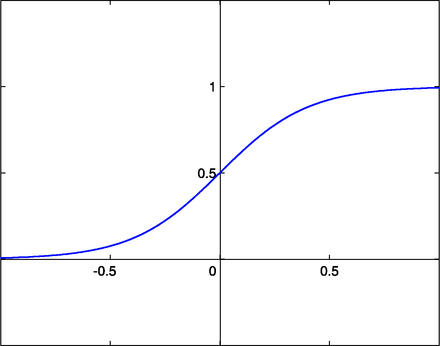

#### ロジスティックモデルは２値分類タスクに限られる
ここでは品種としてIris-Setosa(クラス0)とIris-versicolor(クラス1)のみを考慮。ちなみにIris-virginicaはクラス2で区分される。これが `y`にあたる。

/var/folders/64/qzdb2kkj5c7934_prcdj4xvr0000gn/T/ipykernel_1517/3351863578.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


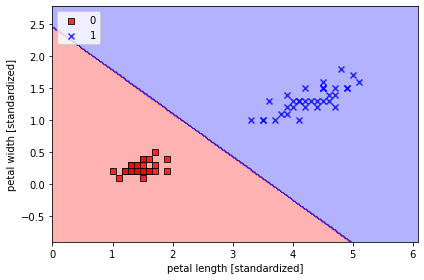

In [ ]:

X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]# 訓練データのうち、クラスラベルが0か1のサンプルを抽出
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]# 正解データ(目的変数)のうち、クラスラベルが0か1のサンプルを抽出
# ロジスティック回帰のインスタンスを生成
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1 )
# トレーニングデータに適合させる
lrgd.fit(X_train_01_subset, y_train_01_subset)
# 決定領域をプロット
plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)
# 軸のラベルを設定
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
# 凡例の設定
plt.legend(loc='upper left')
# 図を表示
plt.tight_layout()
plt.show()


#### 次は３つのクラスに分類できる標準化された訓練データセットでモデルを訓練する。

/var/folders/64/qzdb2kkj5c7934_prcdj4xvr0000gn/T/ipykernel_71109/3351863578.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not  

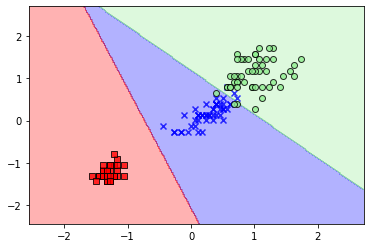

In [11]:
from sklearn.linear_model import LogisticRegression
# ロジスティック回帰のインスタンスを生成
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
# トレーニングデータに適合させる
lr.fit(X_train_std, y_train)
# 決定領域をプロット
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105, 150))
# 軸のラベルを設定
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
# 凡例の設定
plt.legend(loc='upper left')
# 図を表示
plt.tight_layout()
plt.show()



In [15]:
lr.predict_proba(X_test_std[:3, :])# 3つのサンプルのクラス確率を表示
# X_test_std[:3, :]は、X_test_stdの0行目から2行目まで、すべての列を抽出したもの

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

上の結果は1つのデータ点に関するクラスの所属確率を表している。たとえば最初のデータはクラス2に所属する確率が約85%であることを示す。

#### 過学習について
過学習とは、訓練データでは機能するモデルが、テストデータではうまく機能しないという問題のことをいう。過学習が発生しているモデルは「バリアンスが高い」といい、学習不足であるモデルは「バイアスが高い」という。過学習が発生する原因としてデータに対してモデルが複雑すぎるということがある。

#### 対策
対策として、「正則化」に基づいてモデルの複雑さを調整するという方法がある。正則化は共線性を処理する非常に便利な手法。主成分分析でやったみたいにデータからノイズを取り除く。

11個目のコードに出てきているパラメータCは正則化パラメータλに直接関連しており、C = 1/λである。